In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [17]:
import keras
from keras.applications.mobilenet import MobileNet

from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [18]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 224, 224, 3)       166083    
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_4 (Dropout)         (None, 62720)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              64226304  
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                      

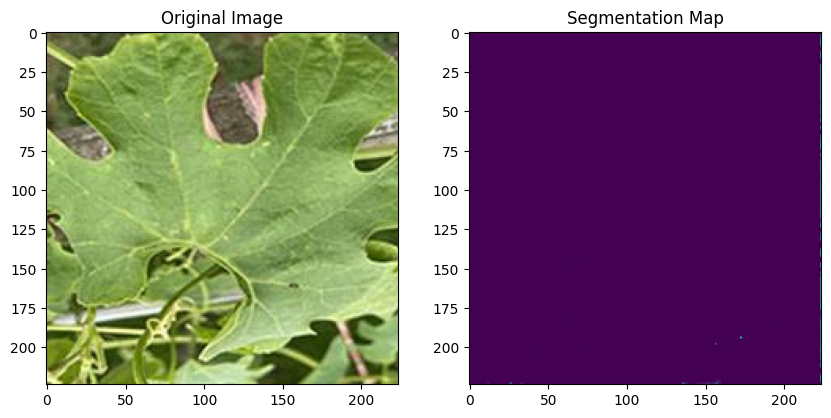

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define U-Net model for segmentation
def unet(input_size=(224, 224, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up2 = UpSampling2D(size=(2, 2))(pool1)
    up2 = Conv2D(64, 2, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv1, up2], axis=3)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)

    # Output segmentation map
    segmentation_output = Conv2D(3, 1, activation='softmax')(conv2)

    return tf.keras.Model(inputs=inputs, outputs=segmentation_output)

# Define MobileNetv2
MobileNetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

MobileNetv2.trainable = False

# Directory paths and parameters
data_dir = '/content/drive/MyDrive/Dataset Argumented 2.0'
target_size = (224, 224)
batch_size = 32

# ... (your existing code for data loading)

# Create the segmentation model
segmentation_model = unet()

# Freeze the weights of the segmentation model
segmentation_model.trainable = False

# Combine segmentation and classification models
combined_model = tf.keras.models.Sequential([
    segmentation_model,
    MobileNetv2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax'),
])

# Compile the combined model
combined_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the summary of the combined model
combined_model.summary()

# Function to visualize segmentation output
def visualize_segmentation(model, img_path, target_size=(224, 224)):
    img = image.load_img('/content/drive/MyDrive/Dataset Argumented 2.0/Train/Healthy/Healthy_original_Copy of IMG_1688.jpg_7a8d8981-0fc2-4e30-826f-c9cd86db921b.jpg', target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Get the segmentation map
    segmentation_map = model.predict(img_array)

    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')

    # Display the segmentation map
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_map[0, :, :, 0], cmap='viridis')  # Assuming the segmentation map is in the first channel
    plt.title('Segmentation Map')

    plt.show()

# Example usage: visualize segmentation output for a specific image
img_path = '/content/drive/MyDrive/Dataset Argumented 2.0/Train/Healthy/Healthy_original_Copy of IMG_1688.jpg_7a8d8981-0fc2-4e30-826f-c9cd86db921b.jpg'  # Replace with the path to your image
visualize_segmentation(segmentation_model, img_path)


In [ ]:
# Function to visualize segmentation output as grayscale image
def visualize_segmentation_grayscale(model, img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Get the segmentation map
    segmentation_map = model.predict(img_array)

    # Convert the segmentation map to grayscale
    segmentation_grayscale = np.sum(segmentation_map, axis=-1)  # Sum across the last axis (assuming channels are the last axis)

    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')

    # Display the segmentation map in grayscale
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_grayscale[0], cmap='gray')
    plt.title('Segmentation Map (Grayscale)')

    plt.show()

# Example usage: visualize segmentation output for a specific image in grayscale
img_path = '/content/drive/MyDrive/Dataset Argumented 2.0/Train/Healthy/Healthy_original_Copy of IMG_1688.jpg_7a8d8981-0fc2-4e30-826f-c9cd86db921b.jpg'  # Replace with the path to your image
visualize_segmentation_grayscale(segmentation_model, img_path)


In [ ]:
history = model.fit(
    x = train,
    validation_data = validation,
    epochs = 5
)

Epoch 1/50
75/75 [==============================] - 648s 8s/step - loss: 6.7647 - accuracy: 0.7796 - val_loss: 0.4632 - val_accuracy: 0.8900
Epoch 2/50
75/75 [==============================] - 35s 472ms/step - loss: 0.3540 - accuracy: 0.9242 - val_loss: 0.6288 - val_accuracy: 0.8767
Epoch 3/50
75/75 [==============================] - 37s 491ms/step - loss: 0.1057 - accuracy: 0.9663 - val_loss: 0.7354 - val_accuracy: 0.8700
Epoch 4/50
75/75 [==============================] - 36s 477ms/step - loss: 0.0770 - accuracy: 0.9775 - val_loss: 0.6515 - val_accuracy: 0.8833
Epoch 5/50
75/75 [==============================] - 35s 473ms/step - loss: 0.0596 - accuracy: 0.9792 - val_loss: 1.0006 - val_accuracy: 0.8500
Epoch 6/50
75/75 [==============================] - 36s 476ms/step - loss: 0.0993 - accuracy: 0.9737 - val_loss: 0.5727 - val_accuracy: 0.8867
Epoch 7/50
75/75 [==============================] - 41s 542ms/step - loss: 0.0730 - accuracy: 0.9792 - val_loss: 0.6065 - val_accuracy: 0.8833
E

In [ ]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

10/10 [==============================] - 92s 10s/step - loss: 2.7040 - accuracy: 0.8539
Accuracy: 0.8538960814476013
Loss: 2.7039732933044434


In [ ]:
test.class_indices

{'Healthy': 0, 'Spot': 1, 'Yellow': 2}

In [ ]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['Yellow', 'Spot', 'Healthy']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

10/10 [==============================] - 2s 80ms/step
              precision    recall  f1-score   support

      Yellow       0.75      1.00      0.85       100
        Spot       0.90      1.00      0.95       100
     Healthy       1.00      0.58      0.74       108

    accuracy                           0.85       308
   macro avg       0.88      0.86      0.85       308
weighted avg       0.89      0.85      0.84       308



<Axes: >

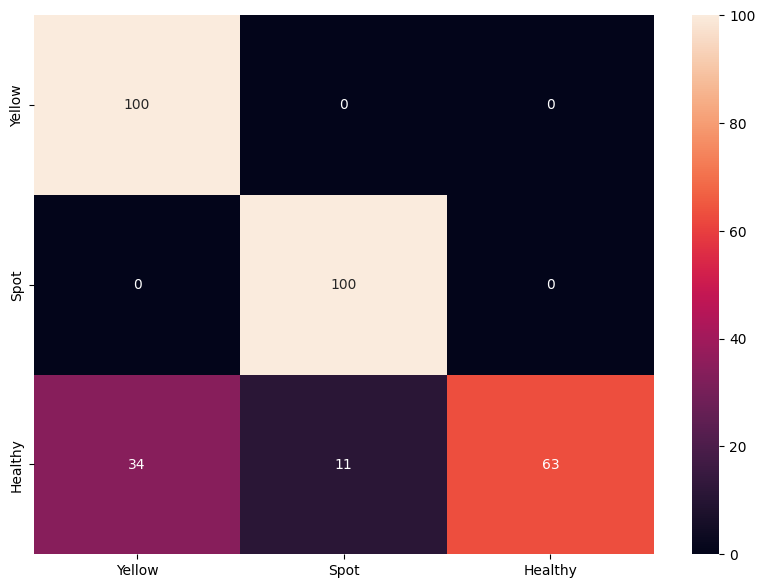

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Yellow', 'Spot', 'Healthy']],
                  columns = [i for i in ['Yellow', 'Spot', 'Healthy']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

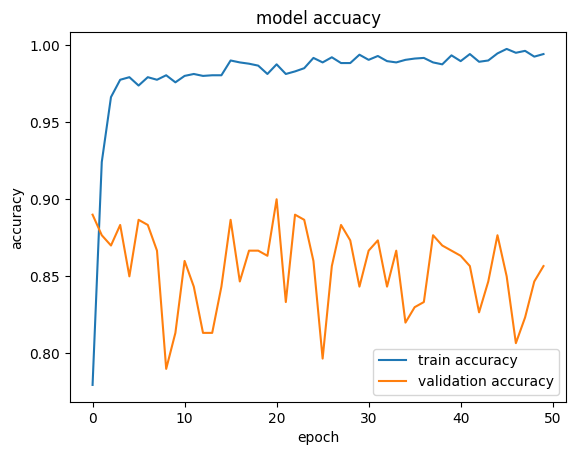

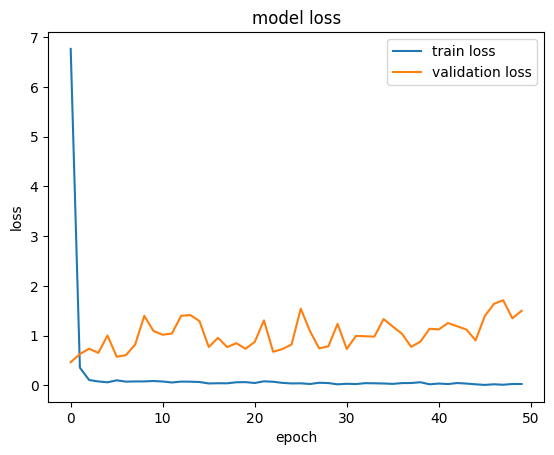

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()